In [1]:
# %matplotlib qt
import f3ast

import numpy as np
import matplotlib.pyplot as plt

### Export calibration stream

In [2]:
calib_strm_savepath = 'calibstrm'

# create safe filename to prevent overwriting
calib_strm_savepath = f3ast.create_safe_savename(calib_strm_savepath)
f3ast.export_spot_calibration(calib_strm_savepath, start_time=1, end_time=15, grid=[5, 3])

Total time:  0:02:00


### Get the image and the data

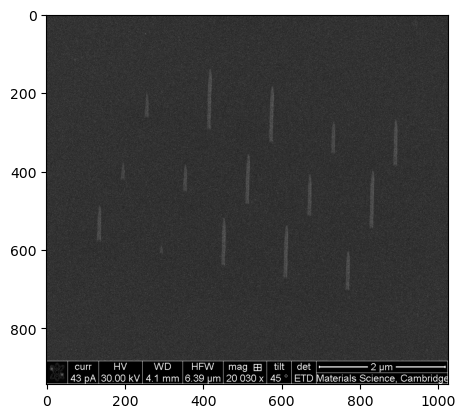

In [3]:
img_path = 'calib1_001.tif'
data_path = 'calib25-11-19_data.txt'
observing_angle = 45

data = np.loadtxt(data_path, delimiter='\t', skiprows=1)
dwell_times = data[:, 0]

img = f3ast.read_image(img_path)
plt.imshow(img)

### Set the scale

In [4]:
# scale_boundaries give upper left corner of scale bar region, as fraction of image size
scale_boundaries = (0.6, 0.93)
scale_bar_size, observing_angle = 2., 45. # in um, deg

# need to use qt backend for interactive scale bar selection
# click at ends of scale bar to get the relation between pixel size and physical length
%matplotlib qt 
tracker = f3ast.select_scale(img, scale_boundaries=scale_boundaries)

80, 22
403, 21


In [5]:
scale_bar_px = np.abs(tracker.scale_markers[1] - tracker.scale_markers[0])
ppn = scale_bar_px / scale_bar_size 
print(f'{ppn:.1f} pixels per micrometer')

161.4 pixels per micrometer


### Process calibration image

18 wires identified.
13 wires selected for analysis.


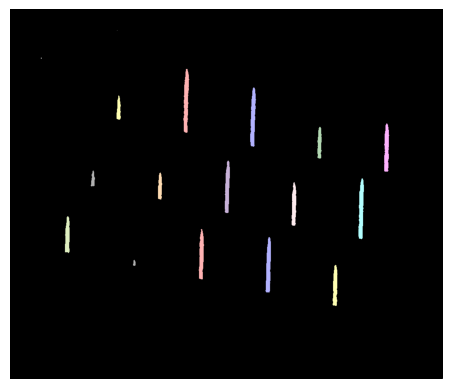

In [6]:
%matplotlib inline

# remove the annotated region (= bottom scale boundary)
img_nobar = f3ast.remove_bottom_bar(img, bottom_factor=scale_boundaries[1])
# threshold the image to extract wire regions
img_thresh = f3ast.threshold_image(img_nobar, thresh=None)

# label image regions, corresponding to calibration wires
label_image, image_label_overlay = f3ast.get_labelled_image(img_thresh)
print(f'{len(np.unique(label_image)) - 1 } wires identified.')

# filter out too small wires
labels = f3ast.filter_small_labels(label_image, min_struct_size=300)
print(f'{len(labels)} wires selected for analysis.')
image_label_overlay = f3ast.label2rgb(label_image, image=img_thresh, bg_label=0)

# show all recognised labels
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(image_label_overlay)

In [7]:
# get real lengths of the wires (in um)
lengths_px = f3ast.get_lengths_px(label_image)
lengths_perspective = np.sort(lengths_px) / ppn
lengths_true = lengths_perspective / np.sin(np.deg2rad(observing_angle))
dwell_times = dwell_times[-lengths_true.size:]

### Fit the model

GR:  0.19843658030389963
k:  1.1360991784447396


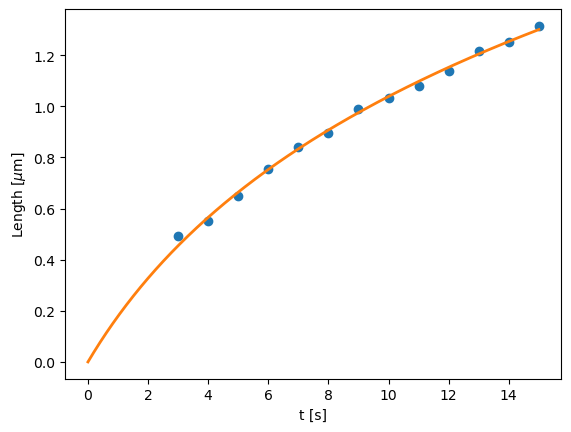

In [8]:
# fit the deposit model and get the parameters
deposit_model, popt, _ = f3ast.DDModel.fit_calibration(dwell_times, lengths_true)

t = np.linspace(0, np.max(dwell_times), 1000)
plt.figure()
plt.plot(t, deposit_model(t, *popt), color='tab:orange', linewidth=2)
plt.scatter(dwell_times, lengths_true)
plt.xlabel('t [s]')
plt.ylabel(r'Length [$\mu$m]');

### Get the sigma calibration structures if necessary

In [1]:
import f3ast
import f3ast.calibration

In [3]:
# check that correct SEM settings are loaded, or define manually
settings = f3ast.load_settings() 

#model = f3ast.RRLModel(struct=None, gr=popt[0], sigma=None)
model = f3ast.RRLModel(struct=None, gr=1., sigma=None)
sigma_list = [3, 4, 5, 6]
file_path = "sigma_calib"

sigma_strm = f3ast.get_sigma_structures(model, sigma_list)
sigma_strm.print_time()

sigma_strm.write(f3ast.create_safe_savename(file_path))

AttributeError: 'str' object has no attribute 'tell'

In [ ]:
sigma_strm.show_on_screen()